In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import sys
sys.path.append("..")
sys.path.append("../..")

import json
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from ast import literal_eval
from typing import List
from functools import reduce

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"grid.color": ".93"})

from src.paper_data_processing import DataProcessing
from src.paper_analysis_hydropower import NationalAnalysisHydropower

In [76]:
paths = json.load(open("../paths_megadroughts.json"))

path_data = Path(paths["path_data"])

path_data_hydro = path_data / "hydropower"
path_data_polygons = path_data / "polygons"
path_swiss_maps = path_data / "maps" / "swissboundaries3d_2023-01_2056_5728/"

path_figs = Path(paths["path_figs"])

In [53]:
data_processing = DataProcessing("../paths_megadroughts.json")

Loading data


# Transform data
Example code

```python
ds = xr.open_dataset(data_processing.path_data_prevah / "netcdf" / "EMC8_2015-2019_RGS_2024.nc")
for nc_file in (data_processing.path_data_prevah / "netcdf_old").glob("*"):
    xr.open_dataset(nc_file).rename({"lat2": "y", "lon2": "x", "RGS": "rgs"}).sortby("time").to_netcdf(data_processing.path_data_prevah / "netcdf" / nc_file.name)
```

# Plot data

In [56]:
gdf_switzerland = gpd.read_file(path_swiss_maps / "swissBOUNDARIES3D_1_4_TLM_LANDESGEBIET.shp").to_crs("EPSG:2056")

## Load BAFU polygons
gdf_polygons = gpd.read_file(path_data_polygons / "EZG_Gewaesser.gpkg")

## Load collocated hydropower locations and BAFU polygons
df_hydropower_polygons = pd.read_json(path_data_hydro / "hydropower_polygons" / "df_hydropower_polygons.json", orient="records")
gdf_hydropower_polygons = gpd.GeoDataFrame(df_hydropower_polygons, geometry=gpd.points_from_xy(df_hydropower_polygons["_x"], df_hydropower_polygons["_y"]), crs="EPSG:2056")

## Load hydropower characteristics
df_wasta = pd.read_excel(path_data_hydro / "stats_hydropower_ch" / "wasta_2023_updated.xlsx")

## Load hydropower production (with simplified efficiency and with/without beta coefficient)
ds_hydropower_generation = xr.open_dataset(path_data_hydro / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_simplified_efficiency.nc")
ds_hydropower_generation_beta = xr.open_dataset(path_data_hydro / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_simplified_efficiency_with_beta.nc")
ds_hydropower_generation_merged = xr.merge([ds_hydropower_generation.rename({"gen": "hp_no_beta"}),
                                            ds_hydropower_generation_beta.rename({"gen": "hp_with_beta"})]).load()

df_hydropower_production_params = pd.read_csv(path_data_hydro / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_parameters.csv")
df_hydropower_production_params.loc[df_hydropower_production_params["Expected yearly generation"] == 0, "Expected yearly generation"] = \
    df_hydropower_production_params[df_hydropower_production_params["Expected yearly generation"] == 0].apply(lambda row: round(row["Capacity"] * 365 * 24 * 1e-6, 2), axis=1)

## Load historical Swiss electricity generation data
df_historical_data = pd.read_csv(path_data / "energy" / "ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv")

In [90]:
monthly_bias_correction_factors = (
    xr.open_dataset(path_data_hydro / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_simplified_efficiency_monthly_bias_correction_factors.nc")
      .bias_correction_factor.load()
      .sel(time=pd.date_range(start="01-01-1992", end="12-01-1992", freq="MS")).values
)

In [91]:
indices_months = ds_hydropower_generation.groupby("time.month").groups
monthly_bias_correction_factors_hourly = np.empty(len(ds_hydropower_generation.time))
for i, month in enumerate(indices_months):
    monthly_bias_correction_factors_hourly[indices_months[month]] = monthly_bias_correction_factors[i]

ds_monthly_bias_correction_factors = xr.DataArray(
    monthly_bias_correction_factors_hourly,
    dims=["time"],
    coords={"time": (["time"], ds_hydropower_generation.time.values)},
)

In [92]:
national_analysis = NationalAnalysisHydropower(gdf_switzerland, gdf_hydropower_polygons, df_wasta,
                                               ds_hydropower_generation_merged * ds_monthly_bias_correction_factors, 
                                               df_hydropower_production_params, 
                                               df_historical_data[["Jahr", "Monat", "Erzeugung_laufwerk_GWh", 
                                                                   "Erzeugung_speicherwerk_GWh", 
                                                                   "Verbrauch_speicherpumpen_GWh"]], 
                                               path_figs)

In [81]:
national_analysis.aggregate_yearly_estimated_generation(with_percentage=False)
national_analysis.aggregate_yearly_estimated_generation_with_operation_start(with_percentage=False)
national_analysis.aggregate_yearly_estimated_generation_per_hp()
national_analysis.aggregate_yearly_estimated_generation_per_hp(reference_period=slice("1991", "2020"))

In [ ]:
national_analysis.aggregate_seasonal_estimated_generation(with_operation_start=False)
national_analysis.aggregate_seasonal_estimated_generation(with_operation_start=True)
national_analysis.aggregate_seasonal_estimated_generation(with_operation_start=False, per_hydropower=True)
national_analysis.aggregate_reference_seasonal_estimated_generation()

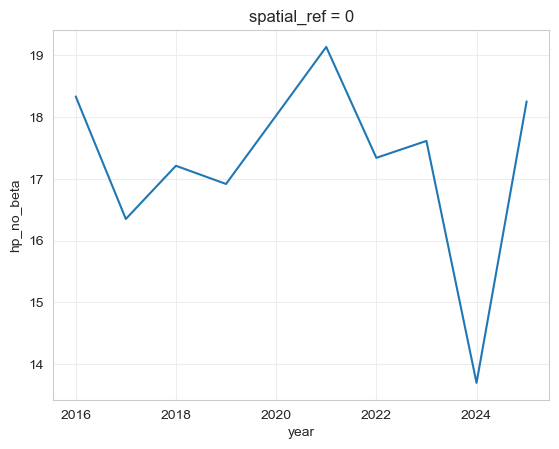

In [101]:
(ds_hydropower_generation_merged * ds_monthly_bias_correction_factors).groupby("time.year").sum().sum("hydropower").sel(year=slice("2016", "2025")).hp_no_beta.plot()